In [4]:
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

In [1]:
import warnings
warnings.filterwarnings('ignore')

# CUPED

Цель данного ноутбука - реализовать CUPED и посмотреть, насколько с помощью этого метода можно снижать дисперсию и повышать мощность тестов.

*Идея CUPED*  
Давайте вместо обычного выборочного среднего в тесте и контроле будет считать следующую статистику:  
$$Z = \overline{Y} - \theta * \overline{X}$$
Здесь $Y_{1..n}$ - значения метрики, $X_{1..n}$ - ковариата - любые данные, на которые наш эксперимент не может оказать влияния  
Заметим, что $E(Z_1 - Z_2) = E(\overline{Y_1} - \overline{Y_2})$ при использовании ковариат с одинаковым матожем.  
Исходя из этого можно в T-тесте использовать разницу $Z_{1,2}$, причем утверждается, что для независимых выборок можно взять  
$$\theta = \frac{cov(Y_{11}, X_{11}) + cov(Y_{21}, X_{21})}{D(X_{11}) + D(X_{21})}$$
и получить минимальную возможную дисперсию, которая вычисляется по следующей формуле: 
$$D(Z_1 - Z_2) = D(\overline{Y_1} - \overline{Y_2}) * (1 - corr^2(Y_{11} - Y_{21}, X_{11} - X_{21}))$$
Так как коэффициент корелляции принимает значения от 0 до 1, то мы в любом случае не увеличим дисперсию разности.

Давайте это реализуем.

In [176]:
def cuped(Y1, Y2, X1, X2):
    theta = (np.cov(Y1, X1)[0, 1] + np.cov(Y2, X2)[0, 1]) / \
            (np.var(X1) + np.var(X2))
    return Y1 - theta * X1, Y2 - theta * X2

In [213]:
def generate_samples(distr, sample_size, eff=1, scale=0.3):
    baseline = distr.rvs(size=sample_size)
    X = baseline + sps.norm(0, baseline.std() * scale).rvs(size=sample_size)
    Y = baseline + sps.norm(0, baseline.std() * scale).rvs(size=sample_size)
    Y *= eff
    return X, Y

На первый взгляд, такой способ генерации выборок может быть некорректен, однако baseline имитирует связь между пользователем до эксперимента и пользователем в эксперименте.  
Если же генерировать X и Y отдельно, то очевидно они будут независимы, что приведет к тому, что в итоге мы получим очень мальнькое $\theta$.  
Дополнительно понять, почему мы генерируем выборки именно так помогает [объяснение](https://youtu.be/pZpUM08mv-E?t=1013) CUPED от Валерия Бабушкина (ссылка с таймкодом).  
Коротко - мы предполагаем, что дисперсия Y зависит от X и всего остального. При помощи CUPED мы избавляется от той части, которая связана с X.  
Если же X и Y независимы, то очевидно, что мы ни от чего не избавимся.  
Конечно такой способ генерации данных не идеален и в работе всегда стоит валидировать тесты на исторических данных.

In [88]:
def get_mean_diff(distr, sample_size=1000, n_iter=10000, eff=1):
    mean_diff = np.zeros(n_iter)
    cuped_mean_diff = np.zeros(n_iter)
    for i in tqdm(range(n_iter)):
        X1, Y1 = generate_samples(distr, sample_size)
        X2, Y2 = generate_samples(distr, sample_size, eff)
        Z1, Z2 = cuped(Y1, Y2, X1, X2)
        mean_diff[i] = np.mean(Y1) - np.mean(Y2)
        cuped_mean_diff[i] = np.mean(Z1) - np.mean(Z2)

    return mean_diff, cuped_mean_diff

In [89]:
def draw_mean_diff_plot(distr, sample_size=1000, n_iter=10000, eff=1):
    mean_diff, cuped_mean_diff = get_mean_diff(distr, sample_size, n_iter, eff)
    
    with sns.axes_style('darkgrid'):
        plt.figure(figsize=(9, 6))
        plt.title('Разность средних, размер выборок: {}, количество итераций: {}'.format(sample_size, n_iter))
        sns.kdeplot(x=mean_diff, lw=2, label='no cuped')
        sns.kdeplot(x=cuped_mean_diff, lw=2, label='cuped')
        plt.legend()
        plt.show()


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:44<00:00, 223.94it/s]


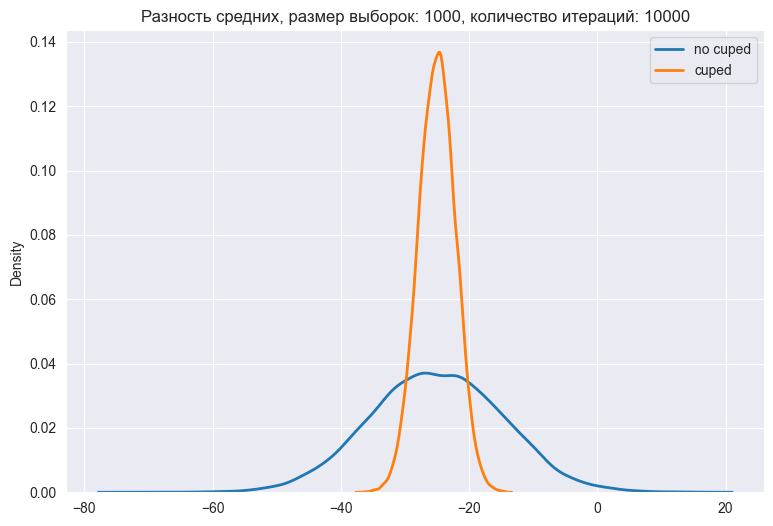

In [126]:
draw_mean_diff_plot(sps.gamma(a=5, scale=100), sample_size=1000, n_iter=10000, eff=1.05)

Как можно видеть, дисперсия разности средних сильно сокращается.  
Давайте посмотрим, как это отражается при проведении теста.

In [233]:
def test(Y1, Y2, alpha=0.05, covariate_1=None, covariate_2=None, use_cuped=False):
    if use_cuped:
        Y1, Y2 = cuped(Y1, Y2, covariate_1, covariate_2)
    _, pvalue = sps.ttest_ind(Y1, Y2)
    return int(pvalue < alpha)

In [129]:
def draw_reject_plot(calc_alpha, left_alpha, right_alpha, t_alpha, ax=None):
    ax.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
    ax.vlines(t_alpha, -1, 1, color='r', lw=5, linestyle='--', alpha=0.6, label=r'Целевой % отвержения')
    ax.fill_between([left_alpha, right_alpha], [0.15] * 2, [-0.15] * 2, color='g', alpha=0.6, label=r'Доверительный интервал для % отвержений')
    ax.scatter(calc_alpha, 0, s=300, marker='*', color='r', label=r'Наблюдаемый % отвержений')
    ax.set_xlim((min(t_alpha, left_alpha) - 0.005, max(t_alpha, right_alpha) + 0.005))
    ax.set_ylim((-0.5, 0.5))
    ax.set_yticks([])

In [222]:
def draw_rejects_plot(calc_val, left, right, teor, labels, doplabel=''):
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(9, 8))
        gs = gridspec.GridSpec(2, 1)
        eps = 0.01
        min_x, max_x = min(calc_val + left + right + [teor]) - eps, max(calc_val + left + right + [teor]) + eps
        for i in range(len(calc_val)):
            ax = plt.subplot(gs[i])
            draw_reject_plot(calc_val[i], left[i], right[i], teor, ax=ax)
            ax.set_ylabel(labels[i])
            ax.set_xlim(min_x, max_x)

        handles, labels = plt.subplot(gs[0]).get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower right', fontsize='small')
        fig.supxlabel('% отвержений')
        fig.suptitle('% Отвержений для различных методов тестирования\n' + doplabel)
        plt.subplots_adjust(top=0.92)

In [236]:
def AB_test(distr, sample_size=10 ** 3, n_iter=10 ** 3, alpha=0.05, eff=1, target=0.05):
    rejects = {'casual': 0, 'cuped': 0}
    for _ in tqdm(range(n_iter)):
        covariate_1, Y1 = generate_samples(distr, sample_size)
        covariate_2, Y2 = generate_samples(distr, sample_size, eff)
        rejects['casual'] += test(Y1, Y2, alpha, use_cuped=False)
        rejects['cuped'] += test(Y1, Y2, alpha, covariate_1, covariate_2, use_cuped=True)
    
    rejects_b = {'est': [], 'left_b': [], 'right_b': []}
    for type_ in rejects.keys():
        left_b, right_b = proportion_confint(rejects[type_], n_iter, method='wilson')
        rejects_b['est'].append(rejects[type_] / n_iter)
        rejects_b['left_b'].append(left_b)
        rejects_b['right_b'].append(right_b)

    doplabel = f'sample_size: {sample_size}, n_iter: {n_iter}, test_impact: {int((eff * 100)) % 100 }% ' + ('(AB test)' if eff != 1 else '(AA test)')
    draw_rejects_plot(rejects_b['est'], rejects_b['left_b'], rejects_b['right_b'], target, labels=list(rejects.keys()), doplabel=doplabel)

100%|██████████| 10000/10000 [00:54<00:00, 184.52it/s]


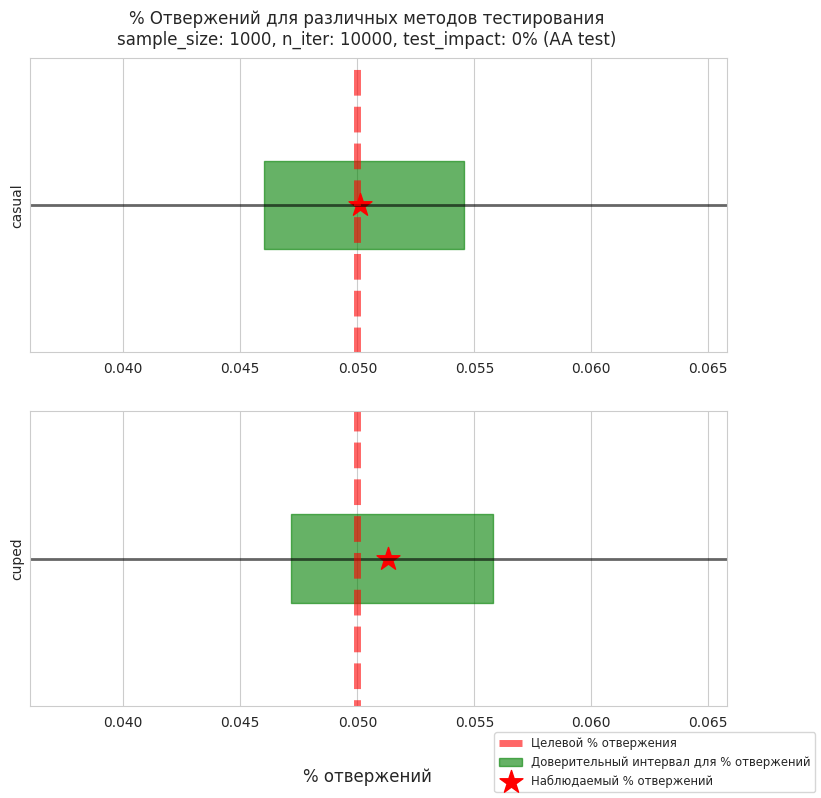

In [224]:
AB_test(sps.gamma(a=5, scale=10), n_iter=10000, sample_size=1000)

100%|██████████| 10000/10000 [00:48<00:00, 204.88it/s]


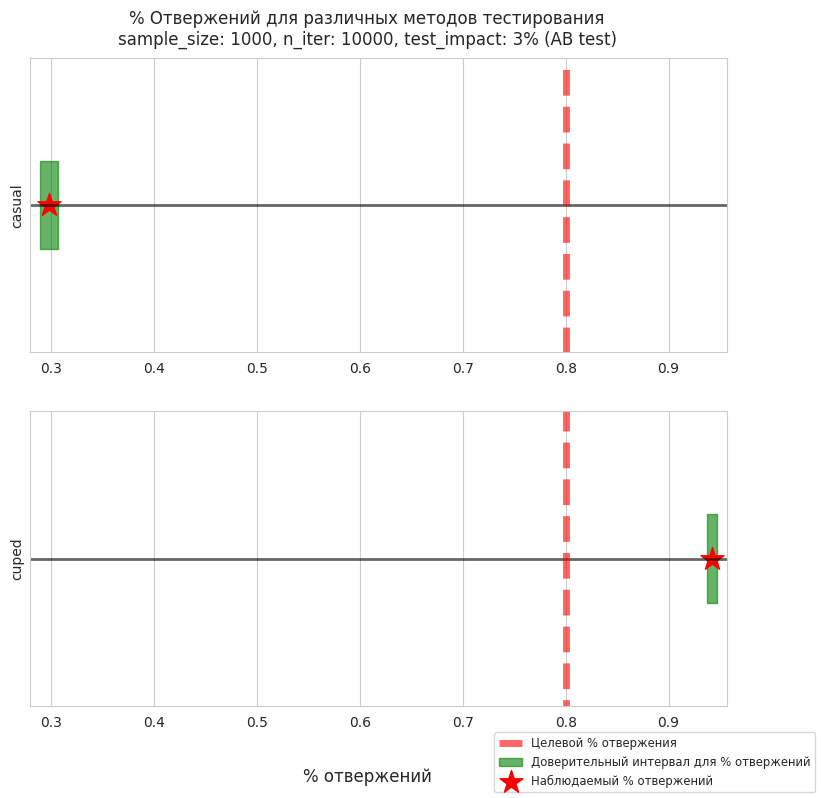

In [227]:
AB_test(sps.gamma(a=5, scale=10), n_iter=10000, sample_size=1000, eff=1.03, target=0.8)

Как видим, тест с использованием CUPED корректен и при этом мощность теста с CUPED кратно возросла.

Попробуем еще одно распределение.

100%|██████████| 10000/10000 [00:48<00:00, 207.01it/s]


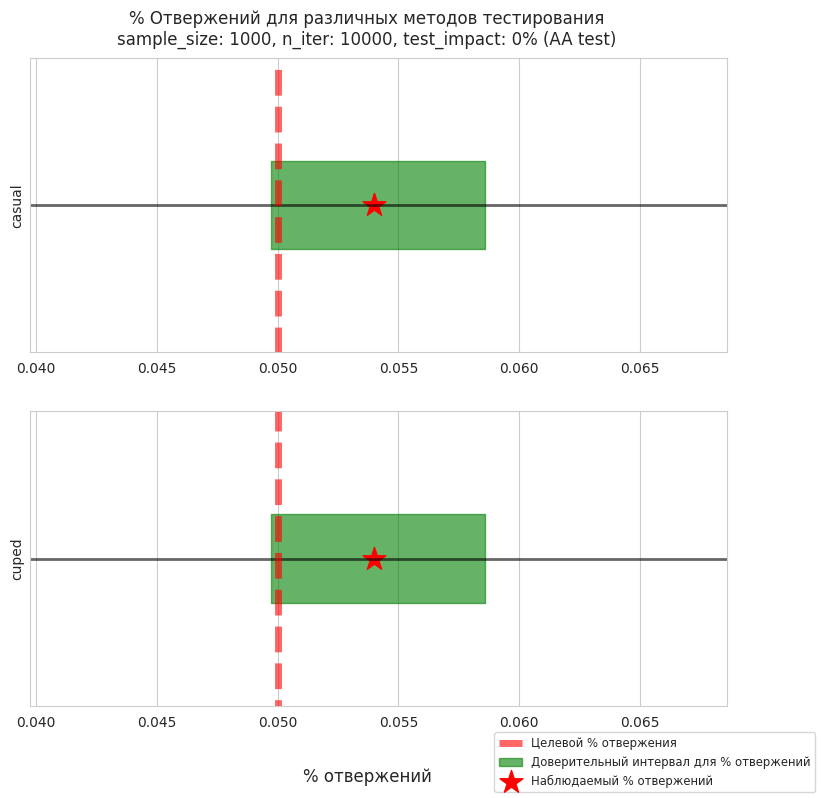

In [225]:
AB_test(sps.expon(scale=100), n_iter=10000, sample_size=1000)

100%|██████████| 10000/10000 [00:47<00:00, 208.89it/s]


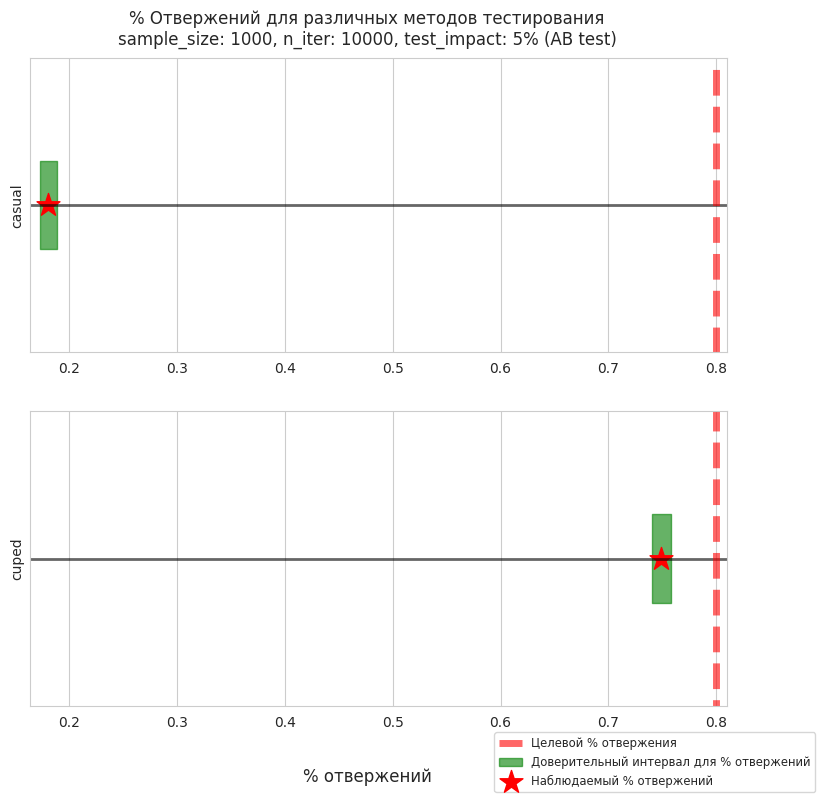

In [226]:
AB_test(sps.expon(scale=100), n_iter=10000, sample_size=1000, eff=1.05, target=0.8)

Результат аналогичен

*Вывод по первой части:*  
CUPED - инструмент, способный кратно увеличивать мощность теста. При желании держать определенный уровень мощности в тесте  
мы можем с его помощью уменьшать необходимое количество наблюдений в выборках, сокращая тем самым время проведения теста.  
При этом CUPED прост в реализации и не требователен к данным, что делает его одновременно простым и полезным инструментом.

# CUMPED

Как мы можем видеть выше, CUPED отлично помогает увеличить мощность теста,   
однако ничего не мешает нам применить преобразование больше 1 раза, чтобы   дополнительно усилить эффект.  
Давайте посмотрим как это работает.

**TBC**   
Для наглядности я хотел в этом параграфе использовать реальные датасеты, но пока не нашел подходящего в окрытом доступе.